# Learning agents in 1559

###### September 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

We've seen in previous notebooks that the basefee in 1559-style transaction fee markets reaches a "stationary" level when users appear in waves with identical distributions of values. This stationary level is robust to strategic users too, who may gain by overbidding early on when the basefee is still performing price discovery, but do not have a clear advantage once that discovery phase is over.

In this notebook, we show that once again the basefee reaches a limit value in the presence of learning agents. Learning in games is a broad and well-studied topic. A plethora of dynamics exist, depending on which data the agents have access to or the update rules of their state.

A particular case, known as the _bandit problem_, has received significant attention. Bandits are the nickname of slot machines, chance devices that offer a payout to some users who pull the bandit's "arm" to try their luck. Multi-arm bandits more generally refers to the decision problem of choosing the optimal bandit, or the machine that pays out the most on average.

One cannot know before trying! So multi-arm bandit learning dynamics generally emphasise the exploration/explotation tradeoff, where one might want to exploit the machine that paid out the most so far, while sometimes picking another one to see if it might work out better.

In the previous notebooks, we left one parameter very much under-determined: the expected waiting time of users. For users who evaluate their costs of waiting to decide whether to transact or not, it is important to have a good estimation of the wait. We went around this issue by looking at two different types of users: some "pessimistic" who expected an arbitrarily chosen wait time of 5 blocks, some "optimistic" who expected next-block inclusion.

This waiting time is a bit like a bandit: picking the "right" one means you don't balk when you could have been included fast enough, or join the queue when you are unlikely to be included. The difference with the slot machines is that you are not playing against some fixed "chance event", but against other players who are also selecting their estimated waiting time and behave accordingly.

In this case, we enter the more general problem of learning in games, where players have some set of actions (e.g., setting their estimated waiting time) among which they want to discover the one that works best in that environment. Since all players are learning, it is not generally the case that the play converges to a "good" situation, or even converges at all. Can we reproduce this here?

### Learning in fee markets

We face a first difficulty, the dynamic environment of the transaction fee market. Most learning settings usually involve a "repeated game"-style environment: all players pick their actions, the payoffs are revealed, repeat. In our case, players who are not included wait in the transaction pool. We could generate all users, see how long they wait and repeat. But we wouldn't be able to capture the dynamic nature of the basefee, who varies according to the load, which is itself dynamic. We do not have a single wave of users getting resorbed before a second wave comes in, but a continuous stream of new users.

A second difficulty: the waiting time is potentially unbounded! Setting a gas price of zero, a user will perhaps never be included. Learning algorithms exist even in the case where users face an infinite universe of actions, but we somewhat avoid this issue by bounding how long users are willing to wait.

Let's start by importing the classes we need for this simulation (see also the [README](../README.md) for details on how to run the notebook yourself).

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants, rng

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.txs import Tx1559

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_users,
    update_basefee,
)

import pandas as pd
import numpy as np
import seaborn as sns

### User behaviour

To accommodate the dynamic environment while having users who learn over time, we'll only ever spawn one batch of users, contrary to our previous notebook. Users are stateful, namely, we give them the following attributes:

- `transacting`: Does the user have a pending transaction? We won't allow our users to have multiple transactions ongoing at the same time.
- `waiting_time`: If the user is transacting, the waiting time indicates for how many blocks the user has stayed in the transaction pool.
- `cut_off`: After `cut_off` blocks of waiting, the user is bored, leaves the pool and resubmits its transaction, with an updated expected waiting time.

### User update rule

As indicated in the last point, the user periodically revises their prior on how long they expect to wait. We start users with a truncated [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). For each possible waiting time (0 block, 1 block, ..., `cut_off` blocks), the user assigns a probability (or weight) that the waiting time is realised.

In [2]:
import math

def poisson_pdf(l, k):
    # Poisson PDF with lambda = l, at k
    return math.exp(-l) * (l ** k) / math.factorial(k)

The timing of the update rule is the following:

**Whenever the user is included _or_ whenever the user is bored, update the expected waiting time.**

How does the update work? Before transacting, the user samples an expected waiting time from their distribution. When the user is included, they compare their sample with the _realised_ waiting time. When the user is bored, the realised waiting time is simply set to their `cut_off`. The update rule is the following:

**When the sample and the realisation match, the user doesn't update its weights. When they mismatch, the user updates their distribution, decreasing the weight given to the sampled estimation (it was a bad one) and increasing the weight given to the realisation (it was the correct one).**

How much increase or decrease happens is governed by the learning rate, with a higher learning rate meaning larger increases and decreases.

In [3]:
def weights_update_rule(weights, expected, realised, learning_rate):
    # We decrease the probability of choosing the expected waiting time
    weights[expected] *= math.exp(-learning_rate)
    # We increase the probability of choosing the realised waiting time
    weights[realised] *= math.exp(learning_rate)
    # Renormalise the weights so that they sum up to 1
    weights /= np.sum(weights)
    
    # Return a copy
    return np.array(weights)

### The `LearningUser` specs

We define our `LearningUser` below. It is an affine user who has a value for the transaction $v$ drawn from some distribution and a cost per unit of waiting time $c$, also drawn randomly. The `LearningUser` has the attributes detailed above and an extra method to update its weights.

In [4]:
class LearningUser(User1559):
    
    cut_off = 10 # How long the user waits for until resubmitting
    
    # User maintains a probability distribution over its waiting time
    weights = np.array([poisson_pdf(0, k) for k in range(cut_off+1)])
    weights /= np.sum(weights)
    
    # State of the user
    transacting = False # Does the user have a pending transaction?
    waiting_time = 0 # How long have they been waiting?
    current_expected_time = cut_off # What is the expected time of their current transaction?
    learning_rate = 1 # How fast are they learning?
    
    def update_weights(self):
        self.weights = weights_update_rule(self.weights, self.current_expected_time, self.waiting_time, self.learning_rate)
    
    def expected_time(self, params):
        self.current_expected_time = rng.choice(np.array(range(self.cut_off+1)), p = self.weights)
        return self.current_expected_time
    
    def create_transaction(self, env):
        if self.transacting:
            return None
        
        basefee = env["basefee"]

        tx_params = self.decide_parameters(env)
        
        expected_time = self.expected_time(params = {})
        if expected_time == self.cut_off:
            return None

        expected_gas_price = min(basefee + tx_params["gas_premium"], tx_params["max_fee"])
        expected_block = self.wakeup_block + expected_time
        expected_payoff = self.payoff({
            "gas_price": expected_gas_price,
            "current_block": expected_block,
        })

        tx = Tx1559(
            sender = self.pub_key,
            params = tx_params,
        )
        return tx
        
    def export(self):
        return {
            **super().export(),
            "user_type": "learning_user",
            "current_expected_time": self.current_expected_time,
        }

In [5]:
def simulate(users_lambda, simulation_steps, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    users = spawn_users(0, users_lambda, UserClass)

    for t in range(simulation_steps):

        # `env` are the "environment variables" of the simulation
        env = {
            "basefee": basefee,
            "current_block": t,
        }
    
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)
        
        decided_users = [user for user in users if user.pub_key in [tx.sender for tx in decided_txs]]
        undecided_users = [user for user in users if user.pub_key not in [tx.sender for tx in decided_txs]]
        
        # Decided users are transacting until they are included in a block
        for user in decided_users:
            user.transacting = True
            
        # Undecided users will be queried again in the next round
        for user in undecided_users:
            if not user.transacting:
                # Users who are transacting are also "undecided" (they return None when asked)
                # But they are still waiting
                # We only reset waiting time of non-transacting, undecided users
                user.waiting_time = 0

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])
        selected_users = [user for user in users if user.pub_key in [tx.sender for tx in selected_txs]]
        for user in selected_users:
            user.update_weights()
            user.transacting = False
            user.waiting_time = 0

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        for user in users:
            user.wakeup_block += 1
            if user.transacting:
                user.waiting_time += 1
                if user.waiting_time == user.cut_off:
                    user.update_weights()
                    user.transacting = False
                    user.waiting_time = 0
                    txpool.remove_txs_from_sender(user.pub_key)
        
        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee, update_speed = 2 ** 7)

    return (pd.DataFrame(metrics), user_pool, chain)

In [6]:
(df, user_pool, chain) = simulate(50, 5000, LearningUser)

In [7]:
df

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,50,50,23,2.000000,1.000000,27
1,1,1.007281,50,23,23,2.007281,1.000000,27
2,2,1.014616,50,23,23,2.014616,1.000000,27
3,3,1.022003,50,23,23,2.022003,1.000000,27
4,4,1.029445,50,23,23,2.029445,1.000000,27
...,...,...,...,...,...,...,...,...
4995,4995,12.034231,50,13,12,12.829256,0.795025,1
4996,4996,12.034983,50,14,12,12.829757,0.794774,2
4997,4997,12.035735,50,16,12,12.830258,0.794523,4
4998,4998,12.036487,50,17,12,12.830760,0.794273,5


<AxesSubplot:xlabel='block'>

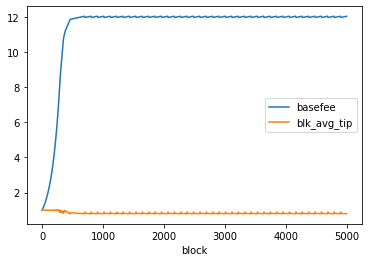

In [8]:
df.plot("block", ["basefee", "blk_avg_tip"])

<AxesSubplot:xlabel='value', ylabel='current_expected_time'>

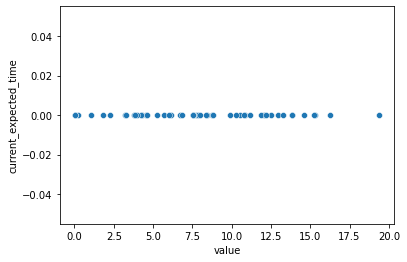

In [9]:
sns.scatterplot(data=user_pool.export(), x="value", y="current_expected_time")